In [35]:
using DataFrames, Statistics, Plots, Measures, CSV

### Zadania
 
1.
 
2. 

3.  Użyć aproksymacji odpowiednimi wielomianami, które najlepiej pasują do zależności czasowych każdego z algorytmów. Stopień wielomianu powinien zgadzać się z teoretyczną złożonoscią. Dodać wykresy uzyskanych wielomianów do wcześniejszych wykresów. **(1 pkt)** Do analizy danych można użyć wybranego narzędzia (Julia, R)

4. Pokazać zniwelowanie efektu Rungego  poprzez użycie wsparcia dla wielomianów Czebyszewa w pakiecie Polynomials. Wymagany wykres. **(1 pkt)**

5. Przybliżenie Pade jest często lepsze niż rozwinięcie w szereg Taylora przy aproksymowaniu funkcji, które posiadają osobliwości. Korzystając ze wsparcia dla aproksymacji Pade w pakiecie Polynomials pokazać dowolny przykład (wraz z wykresem), gdzie takie przybliżenie faktycznie jest lepsze. Można odtworzyć wykres z wykładu albo zainspirować się przykładowym artykułem https://www.hindawi.com/journals/ijcm/2014/587430/ **(1 pkt)**


## Zad1 
Uruchomić 
   - `naive_multiplication(A,B)`, 
   - `better_multiplication(A,B)` 
   - mnożenie BLAS w Julii (`A*B`) 

    dla coraz większych macierzy kwadratowych i zmierzyć czasy. Narysować wykres zależyności czasu od rozmiaru macierzy wraz z słupkami błędów. Wszystkie trzy metody powinny być na jednym wykresie. **(1pkt)**. Do analizy danych można użyć wybranego narzędzia (Julia, R)

In [36]:
# mnożenie macierzy - wersja naiwna
function naive_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    return C
end

naive_multiplication (generic function with 1 method)

In [37]:
function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    return C
end

better_multiplication (generic function with 1 method)

In [38]:
# A*B

In [39]:
df = DataFrame(Nodes=Int[],Naive=Float64[],Better=Float64[], Lib = Float64[])
for n in 5:10:205
    A = rand(n, n);
    B = rand(n, n);
    for j in 1:11
        naive_AB, naive_t = @timed naive_multiplication(A,B)
        better_AB, better_t = @timed better_multiplication(A,B)
        lib_AB, lib_t = @timed A*B
        if j > 1
            push!(df,hcat([n],naive_t, better_t, lib_t))
        end
    end
end

In [40]:
df2 = combine(groupby(df, :Nodes), :Naive => mean, :Better => mean, :Lib => mean, :Naive => std, :Better => std, :Lib => std)
println(df2)

21×7 DataFrame
 Row │ Nodes  Naive_mean  Better_mean  Lib_mean    Naive_std    Better_std   Lib_std     
     │ Int64  Float64     Float64      Float64     Float64      Float64      Float64     
─────┼───────────────────────────────────────────────────────────────────────────────────
   1 │     5  4.5e-7       4.2e-7      5.1e-7      9.71825e-8   9.18937e-8   1.59513e-7
   2 │    15  1.009e-5     4.84e-6     1.83e-6     2.64365e-7   4.27395e-7   4.39823e-7
   3 │    25  4.917e-5     1.931e-5    3.82e-6     4.49815e-7   1.54089e-6   3.4254e-7
   4 │    35  0.00013822   4.896e-5    8.2e-6      1.45052e-6   7.57481e-7   7.10243e-7
   5 │    45  0.00032486   0.00010939  1.808e-5    1.357e-5     1.19686e-5   6.49355e-6
   6 │    55  0.00061022   0.00018607  2.9e-5      4.28714e-6   2.60429e-6   2.2291e-6
   7 │    65  0.00104463   0.00031534  0.00043521  1.33676e-5   1.65569e-5   0.00010031
   8 │    75  0.001693     0.00049169  0.00053198  0.00013344   9.62294e-6   0.00011116
   9 │    85 

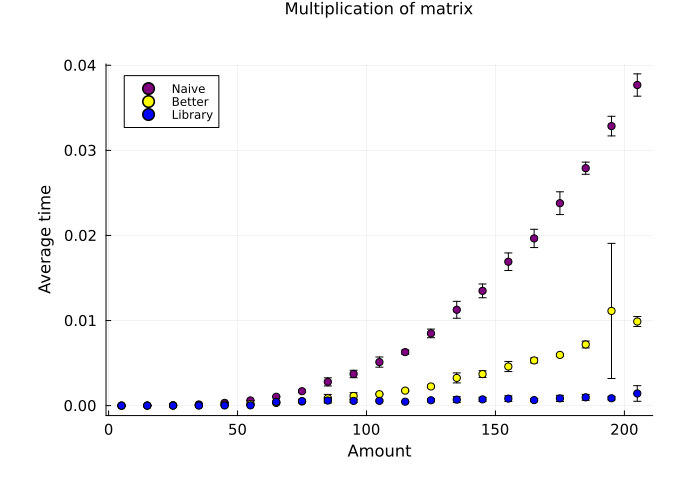

In [41]:
scatter(
    df2.Nodes, 
    size = (700, 500), 
    margin=10mm,
    xtickfontsize=10, 
    ytickfontsize=10, 
    titlefontsize = 11,
    xlabel = "Amount",
    ylabel = "Average time",
    [df2.Naive_mean, df2.Better_mean, df2.Lib_mean], 
    title = "Multiplication of matrix", 
    label = ["Naive"  "Better" "Library"],
    color = [:purple :yellow :blue],
    yerr = [df2.Naive_std df2.Better_std df2.Lib_std], 
    legend = true
)

## ZAD 2
Napisać w języku C:
   - naiwną metodę mnożenia macierzy kwadratowych (wersja 1) 
   - ulepszoną wersję za pomocą zamiany pętli metodę mnożenia macierzy(wersja 2), pamiętając, że w C macierz przechowywana jest wierszami (row major order tzn A11,A12, ..., A1m, A21, A22,...,A2m, ..Anm), inaczej niż w Julii ! 
   - skorzystać z  możliwości BLAS poziom 3 dostępnego w GSL  (przykład uzycia https://www.gnu.org/software/gsl/doc/html/blas.html#examples )
    
    Należy porównywać działanie tych trzech algorytmow bez włączonej opcji optymalizacji kompilatora. Przedstawić wyniki na jednym wykresie tak jak w p.1. (osobno niż p.1). **(1 pkt)**
    
    *(Dla chętnych)* sprawdzić, co się dzieje, jak włączymy optymalizację kompilatora i dodać do wykresu. 
Do analizy danych można użyć wybranego narzędzia (Julia, R)

In [42]:
mydata=CSV.read(input, delim=",",DataFrame)
c_data = combine(groupby(mydata,:1),:2 => mean => :m1,:2=> std => :s1, :3 => mean => :m2, :3 => std => :s2, :4 => mean => :m3, :4 => std => :s3)
print(c_data)

21×7 DataFrame
 Row │ size   m1         s1           m2         s2           m3         s3          
     │ Int64  Float64    Float64      Float64    Float64      Float64    Float64     
─────┼───────────────────────────────────────────────────────────────────────────────
   1 │     5  0.0        0.0          0.0        0.0          3.0e-7     9.48683e-7
   2 │    15  2.1e-6     3.16228e-7   2.2e-6     4.21637e-7   0.0        0.0
   3 │    25  1.12e-5    3.79473e-6   1.0e-5     0.0          1.0e-6     2.23213e-22
   4 │    35  3.35e-5    9.91351e-6   3.15e-5    3.74907e-6   3.1e-6     3.16228e-7
   5 │    45  6.26e-5    2.98887e-6   6.36e-5    6.86699e-6   6.2e-6     2.09762e-6
   6 │    55  0.0001117  3.97352e-6   0.0001102  1.98886e-6   1.01e-5    3.16228e-7
   7 │    65  0.0002108  4.36394e-5   0.000198   2.99481e-5   1.69e-5    2.84605e-6
   8 │    75  0.0002799  5.60654e-6   0.0002931  4.57346e-5   2.49e-5    1.37032e-6
   9 │    85  0.0004104  8.5401e-6    0.0904172  0.284608    

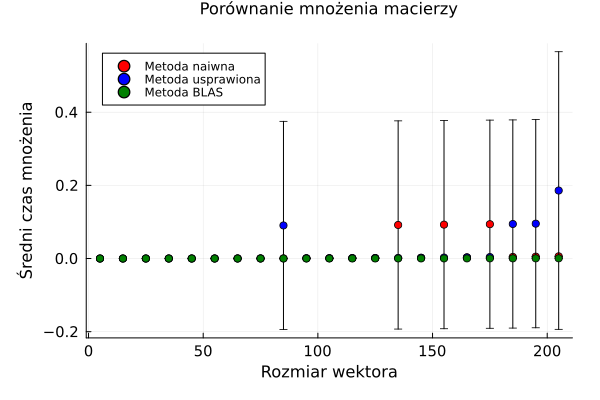

In [43]:
scatter(
    c_data.size, 
    margin=5mm,xtickfontsize=10, 
    ytickfontsize=10, 
    titlefontsize = 11,
    xlabel = "Rozmiar wektora",
    ylabel = "Średni czas mnożenia",
    [c_data.m1,c_data.m2,c_data.m3], 
    title = "Porównanie mnożenia macierzy", 
    legend_position = :topleft, 
    label = ["Metoda naiwna" "Metoda usprawiona" "Metoda BLAS"], 
    color = [:red :blue :green],
    yerr = [c_data.s1 c_data.s2 c_data.s3]
)